In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
num_channels = 3
latent_size = 100
base_size, image_size, batch_size = 64, 64, 64
torch.cuda.set_device("cuda:0")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # makes value in between [-1, 1]
])

dataset = datasets.ImageFolder('/content/gdrive/My Drive/aug-image', transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

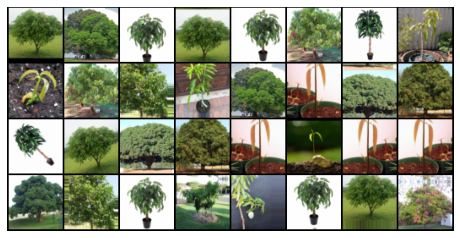

In [ ]:
real_batch = next(iter(loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)))


NETWORKS

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 128, image_size//4, image_size//4)

def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)
                    ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

GENERATOR

In [ ]:
G = nn.Sequential(
    nn.Linear(100, 128 * (image_size//4) ** 2),
    UnFlatten(),
    nn.BatchNorm2d(128),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 128, 3, stride=1, padding=1),
    nn.BatchNorm2d(128, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 64, 3, stride=1, padding=1),
    nn.BatchNorm2d(64, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, num_channels, 3, stride=1, padding=1),
    nn.Tanh(),
)

DESCRIMINATOR

In [ ]:
D = nn.Sequential(
    *discriminator_block(num_channels, 16, bn=False),
    *discriminator_block(16, 32),
    *discriminator_block(32, 64),
    *discriminator_block(64, 128),
    Flatten(),
    nn.Linear(128 * (image_size//2**4) ** 2, 1), 
    nn.Sigmoid()
)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# recursively apply weights initialization on every submodule
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout2d(p=0.25, inplace=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout2d(p=0.25, inplace=False)
  (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Dropout2d(p=0.25, inplace=False)
  (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Dropout2d(p=0.25, inplace=False)
  (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (15): Flatten()
  (16): Linear(in_features=2048, out_features=1, bias

In [ ]:
def draw_my_picture():
    Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_size))))
    img = G(z).cpu().data[0]
    img = img.view((num_channels, image_size, image_size)).transpose(0, 1).transpose(1, 2).cpu().numpy()
    plt.axis('off')
    plt.imshow(img.reshape(image_size, image_size, num_channels))
    plt.show()

In [ ]:
try:
    D.load_state_dict(torch.load('D.pth'))
    G.load_state_dict(torch.load('G.pth'))
except:
    print("Weights not found ):")

Weights not found ):


In [ ]:
cuda = True if torch.cuda.is_available() else False
adversarial_loss = torch.nn.BCELoss()
if cuda:
    G.cuda()
    D.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    Tensor = torch.FloatTensor

TRAINING

  0%|          | 0/30 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


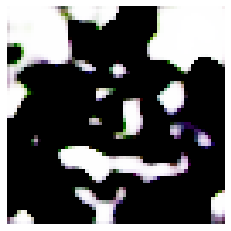

  3%|▎         | 1/30 [07:28<3:36:32, 448.02s/it]

D_loss: 0.6942 G_loss: 0.7394


  7%|▋         | 2/30 [08:31<2:35:18, 332.80s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


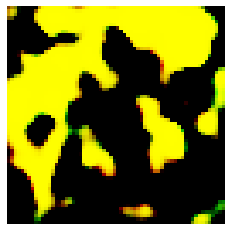

 10%|█         | 3/30 [09:28<1:52:27, 249.89s/it]

D_loss: 0.2831 G_loss: 2.2047


 13%|█▎        | 4/30 [10:24<1:23:07, 191.84s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


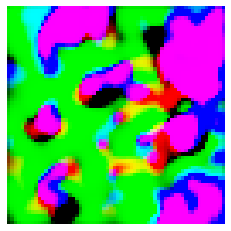

 17%|█▋        | 5/30 [11:20<1:02:57, 151.09s/it]

D_loss: 0.2835 G_loss: 2.0539


 20%|██        | 6/30 [12:16<48:59, 122.48s/it]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


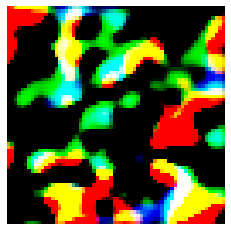

 23%|██▎       | 7/30 [13:12<39:16, 102.47s/it]

D_loss: 0.2815 G_loss: 3.4991


 27%|██▋       | 8/30 [14:08<32:26, 88.47s/it] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


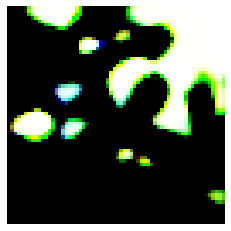

 30%|███       | 9/30 [15:04<27:34, 78.80s/it]

D_loss: 0.3338 G_loss: 3.0230


 33%|███▎      | 10/30 [16:00<23:57, 71.87s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


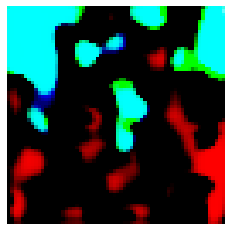

 37%|███▋      | 11/30 [16:55<21:12, 66.98s/it]

D_loss: 0.0049 G_loss: 6.7240


 40%|████      | 12/30 [17:51<19:07, 63.75s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


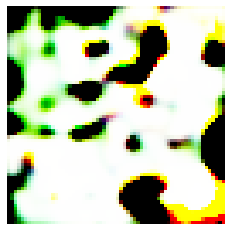

 43%|████▎     | 13/30 [18:47<17:23, 61.40s/it]

D_loss: 0.0753 G_loss: 5.2753


 47%|████▋     | 14/30 [19:43<15:54, 59.64s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


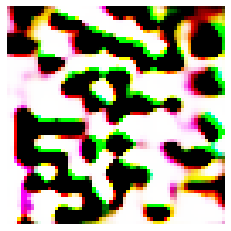

 50%|█████     | 15/30 [20:38<14:36, 58.42s/it]

D_loss: 0.0062 G_loss: 6.9222


 53%|█████▎    | 16/30 [21:34<13:24, 57.48s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


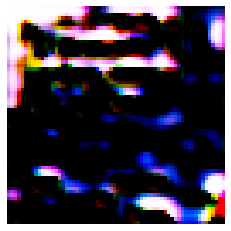

 57%|█████▋    | 17/30 [22:29<12:20, 56.99s/it]

D_loss: 0.1311 G_loss: 3.5775


 60%|██████    | 18/30 [23:25<11:19, 56.66s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


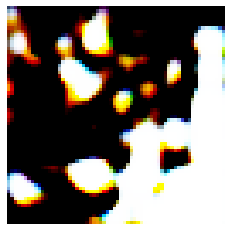

 63%|██████▎   | 19/30 [24:21<10:21, 56.47s/it]

D_loss: 0.1976 G_loss: 3.5303


 67%|██████▋   | 20/30 [25:17<09:22, 56.27s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


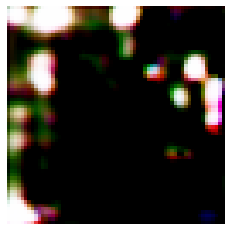

 70%|███████   | 21/30 [26:13<08:25, 56.15s/it]

D_loss: 0.2451 G_loss: 2.3770


 73%|███████▎  | 22/30 [27:09<07:27, 55.95s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


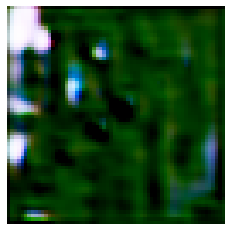

 77%|███████▋  | 23/30 [28:05<06:31, 55.94s/it]

D_loss: 0.5508 G_loss: 1.2846


 80%|████████  | 24/30 [29:00<05:34, 55.79s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


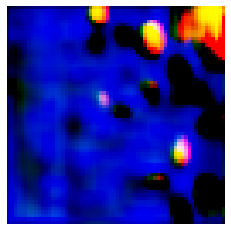

 83%|████████▎ | 25/30 [29:56<04:39, 55.86s/it]

D_loss: 0.0298 G_loss: 9.4565


 87%|████████▋ | 26/30 [30:52<03:43, 55.91s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


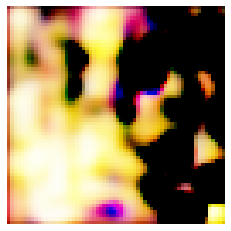

 90%|█████████ | 27/30 [31:48<02:47, 55.81s/it]

D_loss: 0.0778 G_loss: 7.3447


 93%|█████████▎| 28/30 [32:43<01:51, 55.78s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


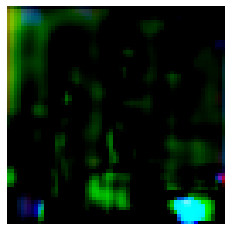

 97%|█████████▋| 29/30 [33:40<00:55, 55.93s/it]

D_loss: 0.0805 G_loss: 7.6752


100%|██████████| 30/30 [34:35<00:00, 69.19s/it]


In [ ]:
num_epochs = 30
learning_rate = 1e-3

optim_G = torch.optim.Adam(G.parameters(), lr=learning_rate)
optim_D = torch.optim.Adam(D.parameters(), lr=learning_rate)
criterion_G = nn.BCELoss()
criterion_D = nn.BCELoss()
for epoch in tqdm(range(num_epochs)):
    for imgs, _ in loader:
        # Train Generator
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        optim_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_size)))) # Sample noise
        gen_imgs = G(z)
        G_loss = adversarial_loss(D(gen_imgs), valid)

        G_loss.backward()
        optim_G.step()

        #  Train Discriminator
        optim_D.zero_grad()
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        D_loss = (real_loss + fake_loss) / 2

        D_loss.backward()
        optim_D.step()
    if epoch % 2 == 0:
        D.eval()
        G.eval()
        draw_my_picture()        
        print(f"D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}")
        torch.save(D.state_dict(), 'D.pth')
        torch.save(G.state_dict(), 'G.pth')
        D.train()
        G.train()

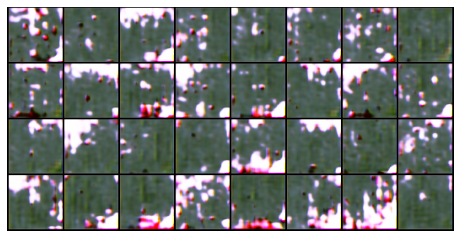

In [ ]:
z = Variable(Tensor(np.random.normal(0, 1, (32, latent_size)))) # Sample noise
gen_imgs = G(z).detach().cpu()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_imgs, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:

# importing libraries 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
  
# Reading image from folder where it is stored 
img = cv2.imread(gen_imgs) 
  
# denoising of image saving it into dst image 
dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15) 
  
# Plotting of source and destination image 
plt.subplot(121), plt.imshow(img) 
plt.subplot(122), plt.imshow(dst) 
  
plt.show() 

SystemError: ignored